# Starbucks Capstone Challenge

### Introduction

This project has a solution for Starbucks challenge!
This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

# Data Preparation & Exploration

In [56]:
import pandas as pd
import numpy as np
import math
import json
import datetime
import pickle
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew #for some statistics
from sklearn.cross_validation import train_test_split

In [57]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [58]:
print(len(portfolio))
print(len(profile))
print(len(transcript))

10
17000
306534


In [59]:
portfolio.isnull().any()

reward        False
channels      False
difficulty    False
duration      False
offer_type    False
id            False
dtype: bool

In [60]:
profile.isnull().any()

gender               True
age                 False
id                  False
became_member_on    False
income               True
dtype: bool

In [61]:
transcript.isnull().any()

person    False
event     False
value     False
time      False
dtype: bool

### Portfolio

In [62]:
print(len(portfolio))
portfolio.head(10)

10


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [63]:
portfolio.difficulty.value_counts()

10    4
5     2
0     2
7     1
20    1
Name: difficulty, dtype: int64

In [64]:
portfolio.duration.value_counts()

7     4
10    2
5     2
4     1
3     1
Name: duration, dtype: int64

In [65]:
portfolio.offer_type.value_counts()

bogo             4
discount         4
informational    2
Name: offer_type, dtype: int64

In [66]:
def clean_portfolio(df):
    '''
    Input: portfolio dataframe.
    
    Output: Cleaned portfolio.
    '''
    portfolio=df.copy()
    
    #id: rename it to offer_id.
    portfolio.rename(columns={'id': 'offer_id'}, inplace=True)
   #offer_type: one-hot encoded
    offer_type= pd.get_dummies(portfolio['offer_type'])
    portfolio.drop('offer_type', axis=1, inplace=True)
    portfolio = pd.concat([portfolio, offer_type], axis=1, sort=False)
    #channels: one-hot encoded
    portfolio['web'] = portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
    portfolio['email'] = portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
    portfolio['mobile'] = portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
    portfolio['social'] = portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
    portfolio.drop('channels', axis=1, inplace=True)
    #portfolio['duration'] = portfolio['duration'] * 24  

    return portfolio

In [67]:
portfolio = clean_portfolio(portfolio)
portfolio.head()

,reward,difficulty,duration,offer_id,bogo,discount,informational,web,email,mobile,social
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0,0,1,1,1
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0,1,1,1,1
2,0,0,4,3f207df678b143eea3cee63160fa8bed,0,0,1,1,1,1,0
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,1,1,1,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,1,1,0,0


In [68]:
portfolio.isnull().any()

reward           False
difficulty       False
duration         False
offer_id         False
bogo             False
discount         False
informational    False
web              False
email            False
mobile           False
social           False
dtype: bool

### Profile

In [69]:
print(len(profile))
profile.head()

17000


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [70]:
profile.age.describe()

count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64

In [71]:
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [72]:
def clean_profile(df):
    '''
    Input: profile dataframe.
    
    Output: Cleaned profile.
    '''
    profile = df.copy()
    
    #Rename id column name to customer_id.
    profile.rename(columns={'id': 'customer_id'}, inplace=True)
    
    #Instead of age = 118, fill it with the mean of the rest ages
    profile['age'] = profile['age'].apply(lambda x: np.nan if x == 118 else x) #Replace age value 118 to 0.
    
    #Change gender column from letters to numeric
    profile['gender'] = profile['gender'].apply(lambda x: 0 if x == 'F' else x)
    profile['gender'] = profile['gender'].apply(lambda x: 1 if x == 'M' else x)
    profile['gender'] = profile['gender'].apply(lambda x: 2 if x == 'O' else x)
    
    #Change date format
    profile.became_member_on = pd.to_datetime(profile.became_member_on, 
                                          format='%Y%m%d')
    #Memebr since how many days
    profile['member_days'] = datetime.datetime.today().date() - pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.date
    profile['member_days'] = profile['member_days'].dt.days
    
    #Add new column for start year
    profile['started_year'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.year
    #Add new column for stsrt month
    profile["started_month"] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.month
    #Delete rows with NaN values
    profile.dropna(inplace=True)

    return profile

In [73]:
profile = clean_profile(profile)
profile.head()

,gender,age,customer_id,became_member_on,income,member_days,started_year,started_month
1,0.0,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,822,2017,7
3,0.0,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,889,2017,5
5,1.0,68.0,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,537,2018,4
8,1.0,65.0,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,613,2018,2
12,1.0,58.0,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,703,2017,11


In [74]:
len(profile)

14825

In [75]:
profile.isnull().any()

gender              False
age                 False
customer_id         False
became_member_on    False
income              False
member_days         False
started_year        False
started_month       False
dtype: bool

In [76]:
profile.describe()

,gender,age,income,member_days,started_year,started_month
count,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000
mean,0.600877,54.393524,65404.991568,968.478988,2016.620169,6.695582
std,0.518114,17.383705,21598.299410,419.205158,1.198245,3.488853
min,0.000000,18.000000,30000.000000,446.000000,2013.000000,1.000000
25%,0.000000,42.000000,49000.000000,654.000000,2016.000000,4.000000
50%,1.000000,55.000000,64000.000000,804.000000,2017.000000,7.000000
75%,1.000000,66.000000,80000.000000,1243.000000,2017.000000,10.000000
max,2.000000,101.000000,120000.000000,2269.000000,2018.000000,12.000000


In [77]:
profile.started_year.value_counts()

2017    5599
2018    3669
2016    3024
2015    1597
2014     662
2013     274
Name: started_year, dtype: int64

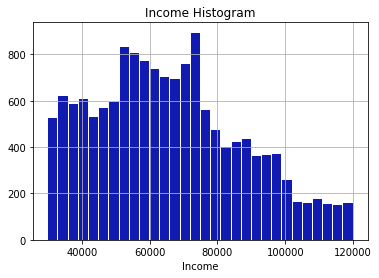

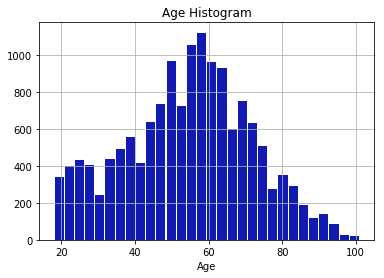

In [78]:
ax = profile.hist(column='income', bins=30, grid=True, color='#111ab1', zorder=1, rwidth=0.9)
ax = ax[0]
for x in ax:
    x.set_title("Income Histogram")
    x.set_xlabel("Income")
ax = profile.hist(column='age', bins=30, grid=True, color='#111ab1', zorder=1, rwidth=0.9)
ax = ax[0]
for x in ax:
    x.set_title("Age Histogram")
    x.set_xlabel("Age")

[Text(0,0.5,'Freq'), Text(0.5,0,'Years')]

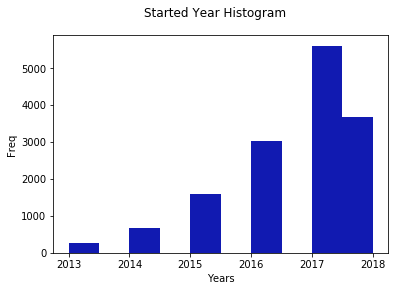

In [79]:
import pylab as pl
ax=profile['started_year'].plot.hist(grid=False, color='#111ab1')
pl.suptitle("Started Year Histogram")
ax.set(xlabel="Years", ylabel="Freq")

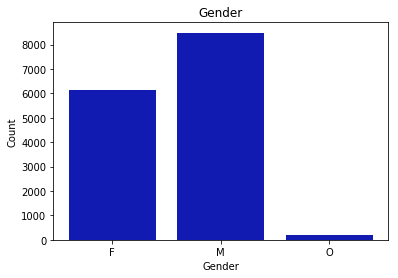

In [80]:
counts = profile.gender.value_counts()
x = ['M','F','O']
data = counts
plt.bar(x,height = data, color='#111ab1');
xlocs, xlabs = plt.xticks()
plt.xlabel('Gender');
plt.ylabel('Count');
plt.title('Gender');

### Transcript

In [81]:
print(len(transcript))
transcript.head()

306534


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [82]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

C:\Users\Ayah\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


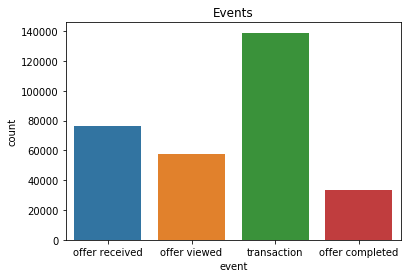

In [83]:
# Create a bar plot 
sns.countplot(x=transcript['event'])
plt.title('Events')
plt.xlabel('event');

In [84]:
def clean_transcript(df):
    
    '''
    Input: transcript dataframe.
    
    Output: Cleaned transcript.
    '''
    transcript = df.copy()
    
    #Rename person column name to customer_id.    
    transcript.rename(columns={'person': 'customer_id'}, inplace=True)
           
    # change amount column type to float
    transcript.amount.astype('float')

    # drop value column
    transcript.drop(columns=['value'], inplace=True)
   
    #Drop customers who don't have profiles data
    matual_ids = transcript['customer_id'].isin(profile['customer_id'])
    transcript = transcript[matual_ids]
    
    #Create days column from the time column
    transcript['time'] = transcript['time'] / 24.0
    
    transcript.drop_duplicates(inplace=True)
    transcript.reset_index(drop=True, inplace=True)
    
    #Extract transactions from transcript data
    transactions = transcript[transcript.event=='transaction'].copy()
    transactions.drop(columns=['offer_id', 'event'], inplace=True)
    
    #Extract offers from transcript data
    offers = transcript[transcript.event!='transaction'].copy()
    
    # One hot encoding for offers
    offers['received'] = offers['event'].apply(lambda x: 1 if x == 'offer received'  else 0)
    offers['viewed'] = offers['event'].apply(lambda x: 1 if x == 'offer viewed' else 0)
    offers['completed'] = offers['event'].apply(lambda x: 1 if x == 'offer completed' else 0)
    offers.drop(columns=['amount', 'event'], inplace=True)
    
    return transcript,transactions,offers

In [85]:
def create_offer(value):
    if list(value.keys())[0] in ['offer id', 'offer_id']:
        return list(value.values())[0]
def create_amount(value):
    if list(value.keys())[0] in ['amount']:
        return list(value.values())[0]


In [86]:
transcript['offer_id'] = transcript.value.apply(create_offer)
transcript['amount'] = transcript.value.apply(create_amount)

transcript, transactions,offers =clean_transcript(transcript)

In [87]:
transcript.head()

,customer_id,event,time,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,e2127556f4f64592b11af22de27a7932,offer received,0.0,2906b810c7d4411798c6938adc9daaa5,NaN
2,389bc3fa690240e798340f5a15918d5c,offer received,0.0,f19421c1d4aa40978ebb69ca19b0e20d,NaN
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0.0,3f207df678b143eea3cee63160fa8bed,NaN
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN


In [88]:
transactions.head()

,customer_id,time,amount
11027,02c083884c7d45b39cc68e1314fec56c,0.0,0.83
11030,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.0,34.56
11032,54890f68699049c2a04d415abc25e717,0.0,13.23
11040,b2f1cd155b864803ad8334cdf13c4bd2,0.0,19.51
11041,fe97aa22dd3e48c8b143116a8403dd52,0.0,18.97


In [89]:
offers.head()

,customer_id,time,offer_id,received,viewed,completed
0,78afa995795e4d85b5d9ceeca43f5fef,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0
1,e2127556f4f64592b11af22de27a7932,0.0,2906b810c7d4411798c6938adc9daaa5,1,0,0
2,389bc3fa690240e798340f5a15918d5c,0.0,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0
3,2eeac8d8feae4a8cad5a6af0499a211d,0.0,3f207df678b143eea3cee63160fa8bed,1,0,0
4,aa4862eba776480b8bb9c68455b8c2e1,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0


In [90]:
transcript.amount.describe()

count    123957.000000
mean         13.996325
std          31.749420
min           0.050000
25%           3.660000
50%          10.800000
75%          19.130000
max        1062.280000
Name: amount, dtype: float64

In [91]:
transcript.event.value_counts()

transaction        123957
offer received      66501
offer viewed        49860
offer completed     32070
Name: event, dtype: int64

In [92]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 8 columns):
gender              14825 non-null float64
age                 14825 non-null float64
customer_id         14825 non-null object
became_member_on    14825 non-null datetime64[ns]
income              14825 non-null float64
member_days         14825 non-null int64
started_year        14825 non-null int64
started_month       14825 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(3), object(1)
memory usage: 1.0+ MB


In [93]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 11 columns):
reward           10 non-null int64
difficulty       10 non-null int64
duration         10 non-null int64
offer_id         10 non-null object
bogo             10 non-null uint8
discount         10 non-null uint8
informational    10 non-null uint8
web              10 non-null int64
email            10 non-null int64
mobile           10 non-null int64
social           10 non-null int64
dtypes: int64(7), object(1), uint8(3)
memory usage: 798.0+ bytes


In [94]:
offers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148431 entries, 0 to 272383
Data columns (total 6 columns):
customer_id    148431 non-null object
time           148431 non-null float64
offer_id       148431 non-null object
received       148431 non-null int64
viewed         148431 non-null int64
completed      148431 non-null int64
dtypes: float64(1), int64(3), object(2)
memory usage: 7.9+ MB


In [95]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123957 entries, 11027 to 272387
Data columns (total 3 columns):
customer_id    123957 non-null object
time           123957 non-null float64
amount         123957 non-null float64
dtypes: float64(2), object(1)
memory usage: 3.8+ MB


In [96]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272388 entries, 0 to 272387
Data columns (total 5 columns):
customer_id    272388 non-null object
event          272388 non-null object
time           272388 non-null float64
offer_id       148431 non-null object
amount         123957 non-null float64
dtypes: float64(2), object(3)
memory usage: 10.4+ MB


In [98]:
#Joine profile, portfolio, offers and transaction data togather
def combine_data(profile, portfolio, offers, transactions):
    data = []
    customer_ids = offers['customer_id'].unique()
    
    # loop through offers
    for i in range(len(customer_ids)):
        # get customer id
        customer_id = customer_ids[i]
        
        # get customer profile
        customer = profile[profile['customer_id'] == customer_id]
        
        # get all offers for the customer
        customer_offers = offers[offers['customer_id'] == customer_id]
        
        # get all transaction for the customer
        customer_transactions = transactions[transactions['customer_id'] == customer_id]
        
        # get the received, completed and viewed offers for the customer
        received_offers = customer_offers[customer_offers['received'] == 1]
        completed_offers = customer_offers[customer_offers['completed'] == 1]
        viewed_offers = customer_offers[customer_offers['viewed'] == 1]
        rows = []
        
        # loop through received offers
        for j in range(received_offers.shape[0]):
            
            # get offer id
            offer_id = received_offers.iloc[j]['offer_id']
            
            # get offer from portfolio
            offer_data = portfolio.loc[portfolio['offer_id'] == offer_id]
            
            # get offer duration
            duration_days = offer_data['duration'].values[0]
            
            # calculate offer's end time
            start_time = received_offers.iloc[j]['time']
            end_time = start_time + duration_days
        
            # find out offers completed before end time
            offer_completed_time =\
            np.logical_and(completed_offers['time'] >= start_time, completed_offers['time'] <= end_time)
            
            # find out viewed within end date
            offer_viewed_time = \
            np.logical_and(viewed_offers['time'] >= start_time, viewed_offers['time'] <=end_time)

            # successful offers are offers that viewed and completed before end time only
            successful_offer = offer_completed_time.sum() > 0 and offer_viewed_time.sum() > 0
            
            # extract transactions occured within time
            transaction_time = \
            np.logical_and(customer_transactions['time'] >= start_time, customer_transactions['time'] <= end_time)
        
            customer_transactions = customer_transactions[transaction_time]
            
            # total amount spent on an offer by the customer 
            total_amount = customer_transactions['amount'].sum()
            
            row = {
                'offer_id': offer_id,
                'customer_id': customer_id,
                'time': start_time,
                'total_amount': total_amount,
                'successful_offer': int(successful_offer),
            }
                
            row.update(offer_data.iloc[0,0:].to_dict())

            row.update(customer.iloc[0,:].to_dict())

            rows.append(row)
        
        data.extend(rows)
    
    data = pd.DataFrame(data)
    return data

In [ ]:
data = combine_data(profile, portfolio, offers, transactions)

In [ ]:
#data.to_csv('My_Startbucks_data_fina1.csv', index=False)

In [102]:
data.successful_offer.value_counts()

0    35136
1    31365
Name: successful_offer, dtype: int64

C:\Users\Ayah\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


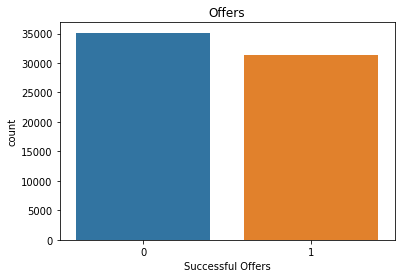

In [138]:
successful_offers_count = data.groupby('successful_offer').sum().reset_index()
# Create a bar plot 
sns.countplot(x=data['successful_offer'])
plt.title('Offers')
plt.xlabel('Successful Offers');
xlabels = ['0', '1']


C:\Users\Ayah\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


([], <a list of 0 Text xticklabel objects>)

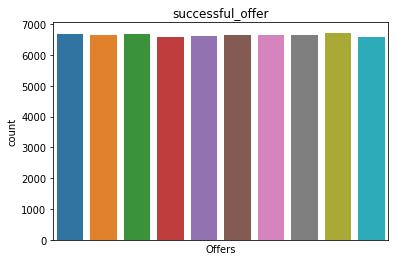

In [104]:
successful_offers_count = data[['offer_id', 'successful_offer']].groupby('offer_id').sum().reset_index()
# Create a bar plot 
sns.countplot(x=data['offer_id'])
plt.title('successful_offer')
plt.xlabel('Offers');
plt.xticks([])

In [106]:
# normalizing some numerical values 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
features = ['time', 'total_amount', 'reward', 'duration', 'duration','age', 'income', 'member_days','started_year','started_month']
X_scaled = data.copy()
X_scaled[features] = scaler.fit_transform(X_scaled[features])
X_scaled.head()

,offer_id,customer_id,time,total_amount,successful_offer,reward,difficulty,duration,bogo,discount,...,email,mobile,social,gender,age,became_member_on,income,member_days,started_year,started_month
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,0.000000,0.036134,1,0.5,5,0.571429,1,0,...,1,1,0,0.0,0.686747,2017-05-09,0.777778,0.243006,0.8,0.363636
1,5a8bc65990b245e5a138643cd4eb9837,78afa995795e4d85b5d9ceeca43f5fef,0.291667,0.000000,0,0.0,0,0.000000,0,0,...,1,1,1,0.0,0.686747,2017-05-09,0.777778,0.243006,0.8,0.363636
2,ae264e3637204a6fb9bb56bc8210ddfd,78afa995795e4d85b5d9ceeca43f5fef,0.708333,0.000000,1,1.0,10,0.571429,1,0,...,1,1,1,0.0,0.686747,2017-05-09,0.777778,0.243006,0.8,0.363636
3,f19421c1d4aa40978ebb69ca19b0e20d,78afa995795e4d85b5d9ceeca43f5fef,0.875000,0.000000,1,0.5,5,0.285714,1,0,...,1,1,1,0.0,0.686747,2017-05-09,0.777778,0.243006,0.8,0.363636
4,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,0.000000,0.000000,0,0.2,10,0.571429,0,1,...,1,1,0,1.0,0.602410,2018-04-26,0.444444,0.049918,1.0,0.272727


# Modeling

In [110]:
features = X_scaled.drop(columns=['successful_offer','offer_id','customer_id', 'became_member_on'])
label = data.successful_offer

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(features.values, label.values, test_size=0.20, random_state=42)

# Show the results of the split
print("{} training".format(X_train.shape[0]))
print("{} testig".format(X_test.shape[0]))


X_train = X_train[:,:].astype('float64')

# test-data: extract offer_id, total_amount and convert other features to float 
#offer_id_test = X_test[:, 0]
#total_amount_test = X_test[:, 1]
X_test = X_test[:, :].astype('float64')

# convert train and test labels to array
y_train = y_train.ravel()
y_test = y_test.ravel()

53200 training
13301 testig


In [124]:
def calculate_accuracy(model):
        # F1 score
        y_pred = model.predict(X_test)
        y_pred=y_pred.round()

        # macro accuracy (macro average)
        mac = f1_score(y_test, y_pred, pos_label=None, average='macro')

        # precision and recall
        recall = recall_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        acc= accuracy_score(y_test, y_pred)
        results = [acc,mac, precision, recall]
        print("acc,f1_score, precision, recall", results)


### Model 1:  Naive Bayes

In [125]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

NB = GaussianNB() 
NB.fit(X_train, y_train)
calculate_accuracy(NB)

acc,f1_score, precision, recall [0.7090444327494173, 0.7060835732215132, 0.6459083273338133, 0.8541732783243415]


### Model 2: Support Vector Machine

In [126]:
from sklearn.svm import SVC
svm = SVC(gamma = 'auto')
svm.fit(X_train, y_train)
calculate_accuracy(svm)

acc,f1_score, precision, recall [0.7322005864220735, 0.7321985141448986, 0.6967825337546683, 0.769755633132339]


### Model 3: Random Forest

In [127]:
RandomForrest = RandomForestRegressor(n_estimators = 100, random_state = 42)
RandomForrest.fit(X_train, y_train)
calculate_accuracy(RandomForrest)

acc,f1_score, precision, recall [0.779490263889933, 0.7787175415057408, 0.7711250603573153, 0.7602348460806093]


In [130]:
RandomForrest = RandomForestRegressor(n_estimators = 400, random_state = 42)
RandomForrest.fit(X_train, y_train)
calculate_accuracy(RandomForrest)

acc,f1_score, precision, recall [0.7804676340124803, 0.7798098275035288, 0.7696109693877551, 0.7659473183116471]


### Model 4: Decision Tree

In [129]:
DecisionTree = DecisionTreeClassifier()
DecisionTree.fit(X_train, y_train)
calculate_accuracy(DecisionTree)

acc,f1_score, precision, recall [0.7232538906849109, 0.7225624853007387, 0.7068666140489345, 0.7105680736274199]
